In [1]:
import os
import pickle
import gzip

from PIL import Image, ImageDraw

import numpy as np
import scipy.integrate

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from einops import repeat, rearrange
from tqdm.notebook import tqdm

In [2]:
plt.style.use("seaborn")
sns.set_style("whitegrid")
sns.set_context("talk")

In [3]:
def imgs_to_ndarray(imgs):
    # Code from https://stackoverflow.com/a/62781370
    magic_number = int.from_bytes(imgs.read(4), 'big')
    image_count = int.from_bytes(imgs.read(4), 'big')
    row_count = int.from_bytes(imgs.read(4), 'big')
    column_count = int.from_bytes(imgs.read(4), 'big')
    image_data = imgs.read()
    images = np.frombuffer(image_data, dtype=np.uint8).reshape((image_count, row_count, column_count))
    return images


def labels_to_ndarray(labels):
    # Code from https://stackoverflow.com/a/62781370
    magic_number = int.from_bytes(labels.read(4), 'big')
    label_count = int.from_bytes(labels.read(4), 'big')
    label_data = labels.read()
    labels = np.frombuffer(label_data, dtype=np.uint8)
    return labels


def read_mnist():
    imgs = gzip.open("../datasets/mnist/train-images-idx3-ubyte.gz", "r")
    labels = gzip.open("../datasets/mnist/train-labels-idx1-ubyte.gz", "r")
    imgs = imgs_to_ndarray(imgs)
    labels = labels_to_ndarray(labels)
    return imgs, labels


def select_data(imgs, labels, digits, n):
    """Selects first `n` images of each digit in `digits`."""
    selected_imgs = []
    for digit in digits:
        mask = labels == digit
        selected_imgs.extend(imgs[mask][:n])
    return np.stack(selected_imgs)


def subsample_min_dist(t, n, min_dist):
    """Subsamples `n` time points from `t` while keeping the smallest distance
    between the time points at least `min_dist`.
    """
    assert n <= len(t), "Too large `n`."
    assert min_dist <= (t.max() - t.min()) / (n - 1), "Too large `min_dist`."
    inds = [0, len(t)-1]
    for i in range(n-2):
        c, c_max = 0, 1e4
        while True:
            ind_i = np.random.choice(len(t), size=1)
            dists = np.abs(t[inds] - t[ind_i])
            if all(dists >= min_dist):
                inds.append(ind_i.item())
                break
            if c > c_max:
                raise RuntimeError("Failed to subsample the time grid. Use smalled `n` or `min_dist`.")
            c += 1
    return t[sorted(inds)]


def generate_irregular_time_grid(T, M, min_dist, seed=None):
    if seed is not None:
        np.random.seed(seed)
    t = np.linspace(0, T, 100*M)
    t = subsample_min_dist(t, M, min_dist)
    return t


def pickle_data(data_dict: dict[str, list], path: str ="./") -> None:
    if not os.path.isdir(path):
        os.makedirs(path)
    for name, data in data_dict.items():
        with open(path+name+".pkl", "wb") as f:
            pickle.dump(data, f, protocol=4)


class MNISTDrawer():
    def __init__(self, img, pad_size=2) -> None:
        self.img = img
        self.img_width = img.shape[0]
        self.img_height = img.shape[1]
        self.pad_size = pad_size

    def get_image(self, angle):
        image = Image.fromarray(self.img)
        image = image.rotate(angle, resample=Image.BICUBIC)
        image = np.pad(np.array(image), (self.pad_size, self.pad_size))
        return image


def generate_data(img, T, M, regular, seed=None):
    pad_size = 2
    mnist_drawer = MNISTDrawer(img, pad_size)

    if regular is True:
        t = np.linspace(0, T, M)
    else:
        t = generate_irregular_time_grid(T, M, T/(4*(M-1)), seed=seed)
        # t = generate_irregular_time_grid(T, M, dt=T/(M-1), seed=seed)

    y = np.empty((1, M, 1, (img.shape[0]+2*pad_size)**2), dtype=np.uint8)
    y_raw = np.empty((1, M, 1, 2), dtype=np.float32)

    if seed is not None:
        np.random.seed(seed)

    for i in range(1):
        theta_0 = np.random.rand() * (2 * np.pi)
        omega = np.pi * (1 + np.random.rand())

        theta = theta_0 + omega * t

        y_raw[i, :, 0, 0] = theta / np.pi * 180  # radians to angles
        y_raw[i, :, 0, 1] = omega / np.pi * 180  # radians to angles
        y_raw[i, :, 0, 0] %= 360

        # Generate images from angles.
        mnist_imgs = np.stack([mnist_drawer.get_image(theta_i) for theta_i in y_raw[i, :, 0, 0]]).reshape(M, -1)
        y[i, :, 0, :] = mnist_imgs

    return t, y, y_raw  # Shapes - y: (1, M, 1, 32**2), y_raw: (1, M, 1, 2), t: (M, )


#### Generate Data

In [4]:
# NOTE: Download train-images-idx3-ubyte.gz and train-labels-idx1-ubyte.gz from http://yann.lecun.com/exdb/mnist/ and save it to .../datasets/mnist/ first.

SEED = 1545

S = 5000  # number of simulations (5000)
M = 51  # number of time points (51)
T = 2.0  # terminal time (1.0)
regular = True  # regular/irregular grid flag

y = []  # data (image)
y_raw = []  # raw data (angle and angular velocity)
t = []  # time grids

imgs, labels = read_mnist()
imgs = select_data(imgs, labels, digits=[3], n=S)

# np.random.seed(SEED)
for i in tqdm(range(S), total=S):
    t_i, y_i, y_raw_i = generate_data(imgs[i], T, M, seed=SEED+i, regular=regular)
    t.append(t_i.reshape(-1, 1))
    y.append(y_i[0])
    y_raw.append(y_raw_i[0])


a, b = int(0.8*S), int(0.9*S)
t_train, t_val, t_test = t[0:a], t[a:b], t[b:]
y_train, y_val, y_test = y[0:a], y[a:b], y[b:]

if regular:
    pickle_data({"t": t_train, "y": y_train}, path=f"../datasets/rmnist_unif/train/")
    pickle_data({"t": t_val, "y": y_val}, path=f"../datasets/rmnist_unif/val/")
    pickle_data({"t": t_test, "y": y_test}, path=f"../datasets/rmnist_unif/test/")
else:
    pickle_data({"t": t_train, "y": y_train}, path=f"../datasets/rmnist/train/")
    pickle_data({"t": t_val, "y": y_val}, path=f"../datasets/rmnist/val/")
    pickle_data({"t": t_test, "y": y_test}, path=f"../datasets/rmnist/test/")

  0%|          | 0/100 [00:00<?, ?it/s]

len(t_train)=80 len(t_val)=10 len(t_test)=10 
 len(y_train)=80 len(y_val)=10 len(y_test)=10 



#### Look at the data

In [44]:
print(
    f"Minimum number of time points: {np.min([ti.shape[0] for ti in t])}\n"
    f"Maximum number of time points: {np.max([ti.shape[0] for ti in t])}\n\n"

    f"Minimum time: {np.min([ti[0, 0] for ti in t])}\n"
    f"Maximum time: {np.max([ti[-1, 0] for ti in t])}\n\n"

    f"Minimum temporal distance: {np.min([np.diff(ti.ravel()) for ti in t]):.3f}\n"
    f"Maximum temporal distance: {np.max([np.diff(ti.ravel()) for ti in t]):.3f}\n\n"

    f"Minimum angle: {np.min([yi[:, 0, 0].min() for yi in y_raw]):.1f}\n"
    f"Maximum angle: {np.max([yi[:, 0, 0].max() for yi in y_raw]):.1f}\n\n"

    f"Minimum angular velocity: {np.min([yi[:, 0, 1].min() for yi in y_raw]):.1f}\n"
    f"Maximum angular velocity: {np.max([yi[:, 0, 1].max() for yi in y_raw]):.1f}\n\n"
)

Minimum number of time points: 51
Maximum number of time points: 51

Minimum time: 0.0
Maximum time: 2.0

Minimum temporal distance: 0.040
Maximum temporal distance: 0.040

Minimum angle: 0.0
Maximum angle: 360.0

Minimum angular velocity: 180.0
Maximum angular velocity: 359.9




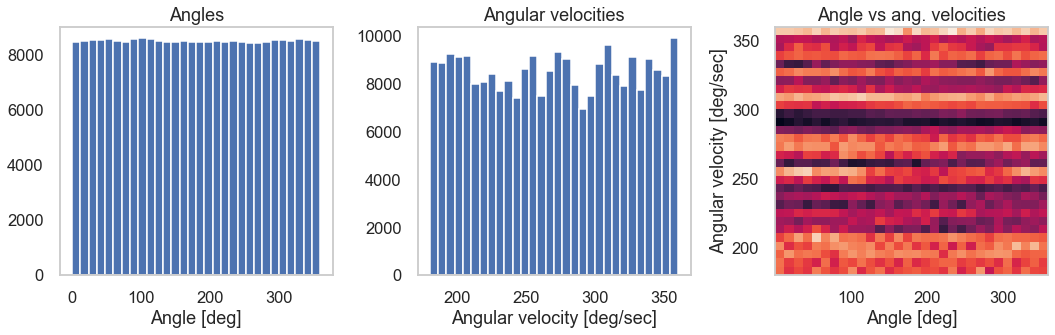

In [45]:
angles = np.concatenate([yi[:, 0, 0] for yi in y_raw])
angular_velocities = np.concatenate([yi[:, 0, 1] for yi in y_raw])

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    ax[i].grid(False)

ax[0].hist(angles, bins=30)
ax[0].set_title("Angles")
ax[0].set_xlabel("Angle [deg]")

ax[1].hist(angular_velocities, bins=30)
ax[1].set_title("Angular velocities")
ax[1].set_xlabel("Angular velocity [deg/sec]")

ax[2].hist2d(angles, angular_velocities, bins=30)
ax[2].set_title("Angle vs ang. velocities")
ax[2].set_xlabel("Angle [deg]")
ax[2].set_ylabel("Angular velocity [deg/sec]")

fig.tight_layout()

plt.show()

Minimum number of time points before 0.300 sec.: 8
Minimum number of time points before 0.300 sec.: 8


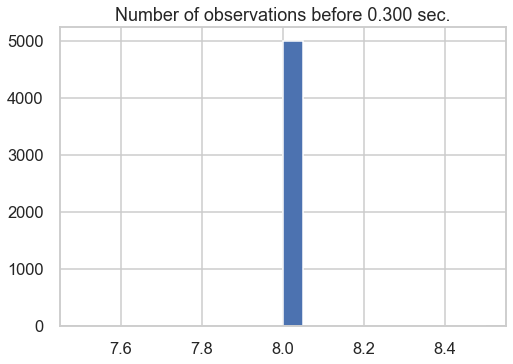

In [46]:
t_inf = 0.15 * T
t_inf_size = np.array([sum(ti.ravel() <= t_inf) for ti in t])

print(
    f"Minimum number of time points before {t_inf:.3f} sec.: {np.min(t_inf_size)}\n"
    f"Minimum number of time points before {t_inf:.3f} sec.: {np.max(t_inf_size)}"
)

plt.hist(t_inf_size, bins=20)
plt.title(f"Number of observations before {t_inf:.3f} sec.")
plt.show()

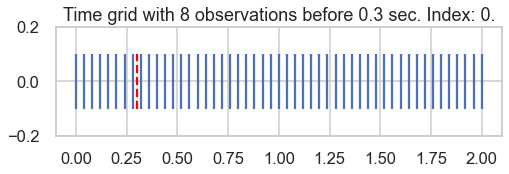

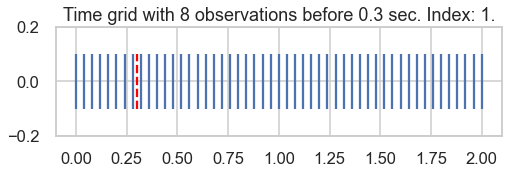

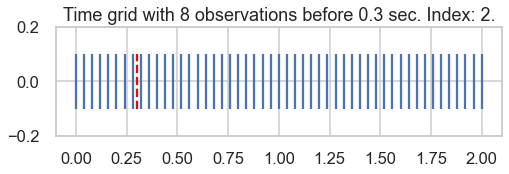

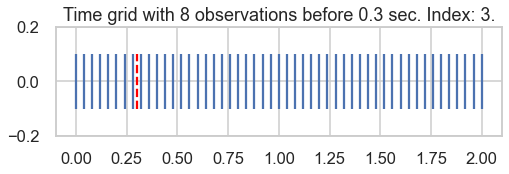

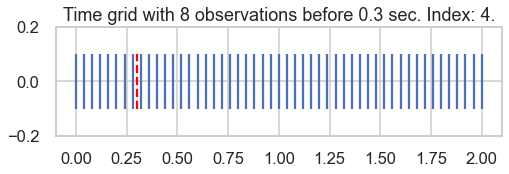

In [47]:
size = 8
inds_for_size = np.argwhere(t_inf_size == size).ravel()

for i in range(min(5, len(inds_for_size))):
    fig, ax = plt.subplots(1, 1, figsize=(8, 2))
    ax.vlines(t[inds_for_size[i]].ravel(), -0.1, 0.1)
    ax.vlines(t_inf, -0.1, 0.1, color="r", linestyle="--")
    ax.set_ylim(-0.2, 0.2)
    ax.set_title(f"Time grid with {size} observations before {t_inf:.1f} sec. Index: {inds_for_size[i]}.")
    plt.show()

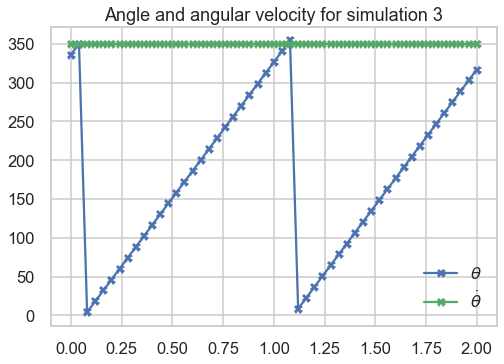

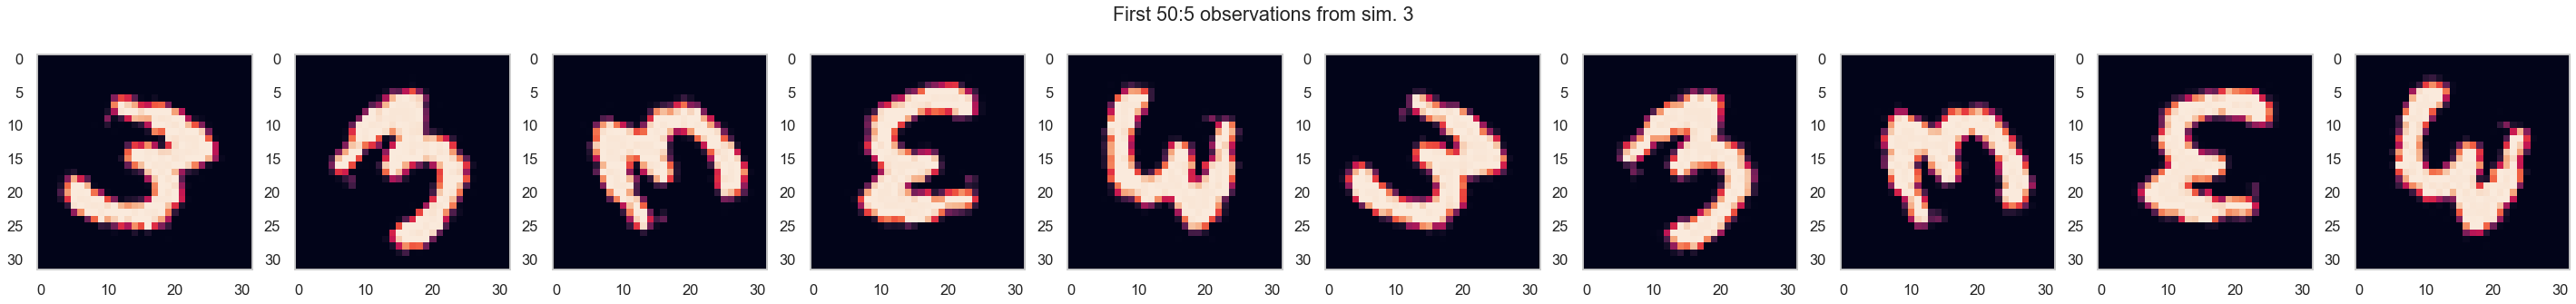

In [48]:
sim_ind = 3

plt.plot(t[sim_ind].ravel(), y_raw[sim_ind][:, 0, 0], "X-", label=r"$\theta$")
plt.plot(t[sim_ind].ravel(), y_raw[sim_ind][:, 0, 1], "X-", label=r"$\dot{\theta}$")
plt.title(f"Angle and angular velocity for simulation {sim_ind}")
plt.legend()
plt.show()

n, skip = 10, 5
fig, ax = plt.subplots(1, n, figsize=(n*5, 5))
for i in range(n):
    ax[i].grid(False)
    ax[i].imshow(y[sim_ind][i*skip, :, :].astype(np.float32).reshape(32, 32))
fig.suptitle(f"First {n*skip}:{skip} observations from sim. {sim_ind}")
plt.show()

In [25]:
pca_input = []
for yi in y:
    pca_input.extend(yi[:, 0, :])
pca_input = np.array(pca_input)

pca = PCA(n_components=32, whiten=False)
pca_output = pca.fit_transform(pca_input)


fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].plot(pca.explained_variance_ratio_)
ax[0].set_title("Explained variance ratio")
ax[0].set_xlabel("PCA components")

ax[1].plot(np.cumsum(pca.explained_variance_ratio_))
ax[1].set_title("Cumulative explained variance ratio")
ax[1].set_xlabel("PCA components")

plt.show()